In [1]:
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from IPython import display
from common import *

np.random.seed(123)
tf.random.set_random_seed(123)

In [2]:
def make_spirals(n_samples):
    n = np.sqrt(np.random.rand(n_samples // 2)) * 540 * (2 * np.pi) / 360
    d1x = - np.cos(n) * n + np.random.rand(n_samples // 2) * 0.5
    d1y =   np.sin(n) * n + np.random.rand(n_samples // 2) * 0.5
    x = np.concatenate([np.stack([ d1x,  d1y], axis=1),
                       np.stack([-d1x, -d1y], axis=1)]) / 3

    x = (x - x.min())/(x - x.min()).max()
    x = (x - 0.5)*0.5 + 0.5
    return x

def make_dataset():
    # Make two circles
    x, y = make_circles(n_samples=2000, factor=.1, noise=.1)
    x = (x - x.min())/(x - x.min()).max()
    # Replace the inner circle with the grid
    x[y==1] = make_spirals((y==1).sum())
    return x, y

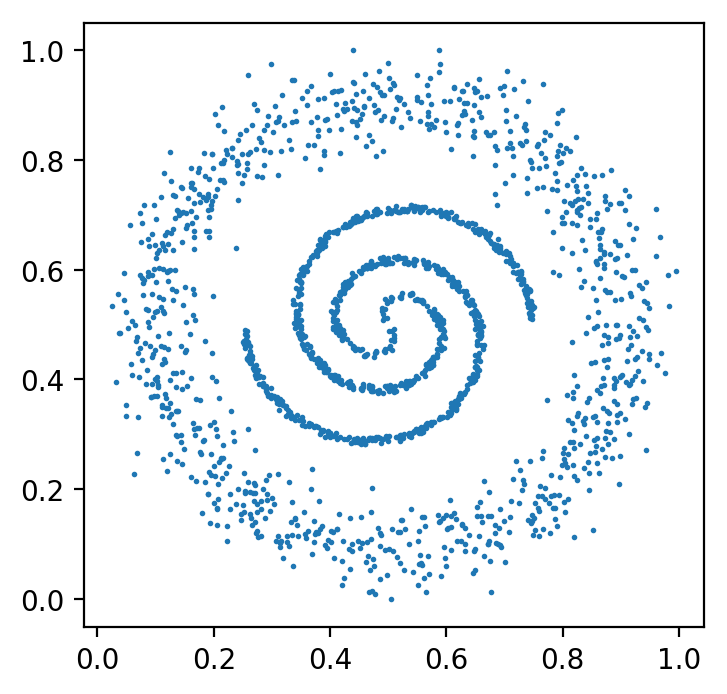

In [3]:
x,y = make_dataset()
plt.figure(figsize=(4, 4), dpi=200)
plt.plot(x[:, 0], x[:, 1], 'o', markersize=1)

In [4]:

x_train, y_train = make_dataset()
tf.reset_default_graph()
detector = Model(var_scope='detector', hidden_sizes=[500]*5)
detector_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='detector')

x_train_others = x_train[y_train == 0]
x_train_target = x_train[y_train == 1]
y_train_others = y_train[y_train == 0]
y_train_target = y_train[y_train == 1]

attack_config = {'max_distance': 0.6, 'num_steps': 30, 
                 'step_size': 0.03, 'random_start': True,
                 'norm': 'Linf', 'optimizer': 'adam',
                 'x_min': 0.0, 'x_max': 1.0, 
                 'batch_size': x_train_others.shape[0]}
attack = PGDAttackDetector(detector, **attack_config)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [6]:
optimizer = tf.train.AdamOptimizer(5e-4)
# optimizer = tf.train.MomentumOptimizer(0.01, momentum=0.9)
train_step = optimizer.minimize(detector.xent)
sess.run(tf.variables_initializer(optimizer.variables()))

1.0 0.0


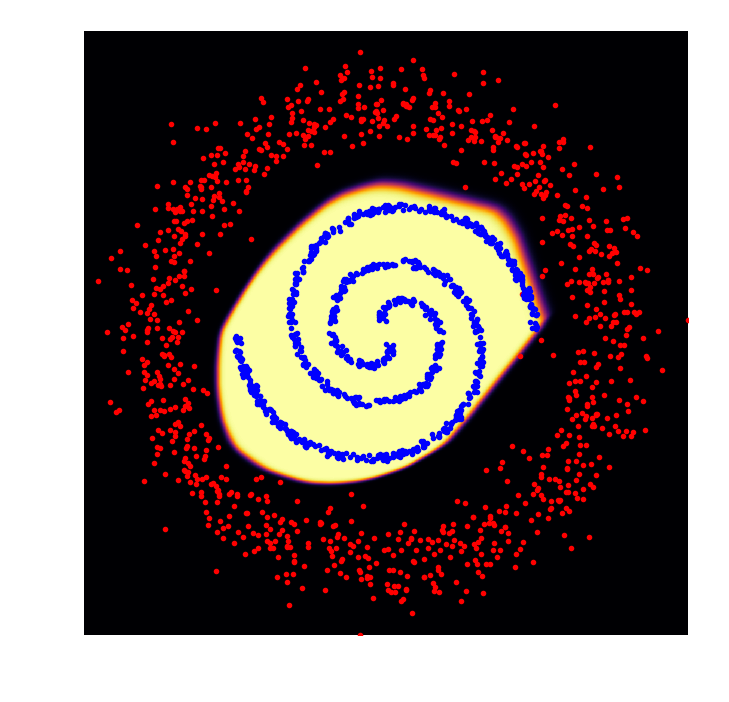

In [7]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()

for i in range(500):
    sess.run(train_step,feed_dict={detector.x_input: x_train, detector.y_input: y_train})
plot_detector(detector, x_train, y_train, ax, sess)
plt.show()

0.95736396 0.0


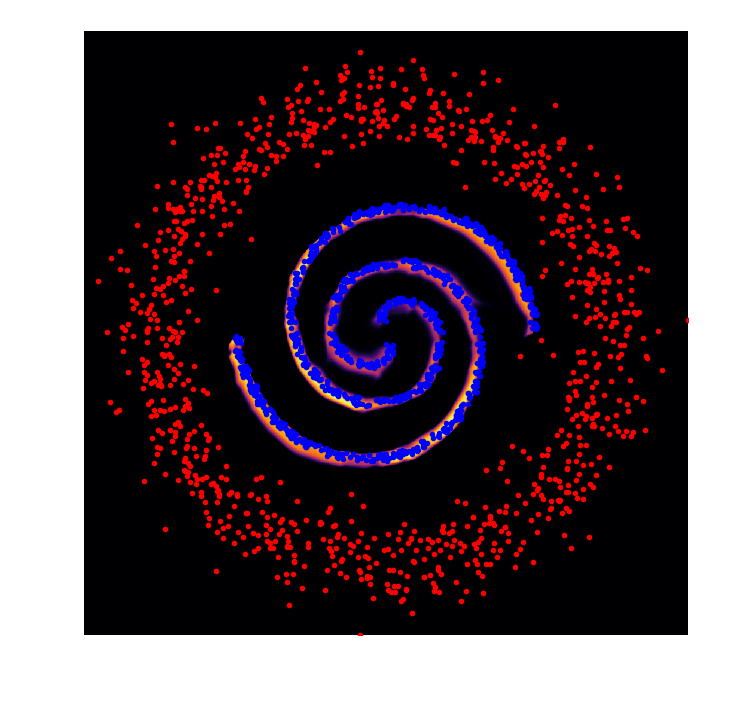

In [8]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()

for i in range(15000):
            x_train_others_adv = attack.perturb(x_train_others,
                                            None,
                                            sess,
                                            verbose=False)
            x_train_with_adv = np.concatenate(
                [x_train_target, x_train_others_adv])
            y_train_with_adv = np.concatenate([y_train_target, y_train_others])
            
#             if i % 1000 == 0:
#                 plot_detector(detector,x_train_with_adv, y_train_with_adv, ax, sess)
#                 display.clear_output(wait=True)
#                 display.display(plt.gcf())


            sess.run(train_step,
                     feed_dict={
                         detector.x_input: x_train_with_adv,
                         detector.y_input: y_train_with_adv
                     })

# plot_detector(detector, x=None, y=None, ax=ax, class0_marker='o')
plot_detector(detector, x_train, y_train, ax, sess)

plt.show()

0.95736396 0.0


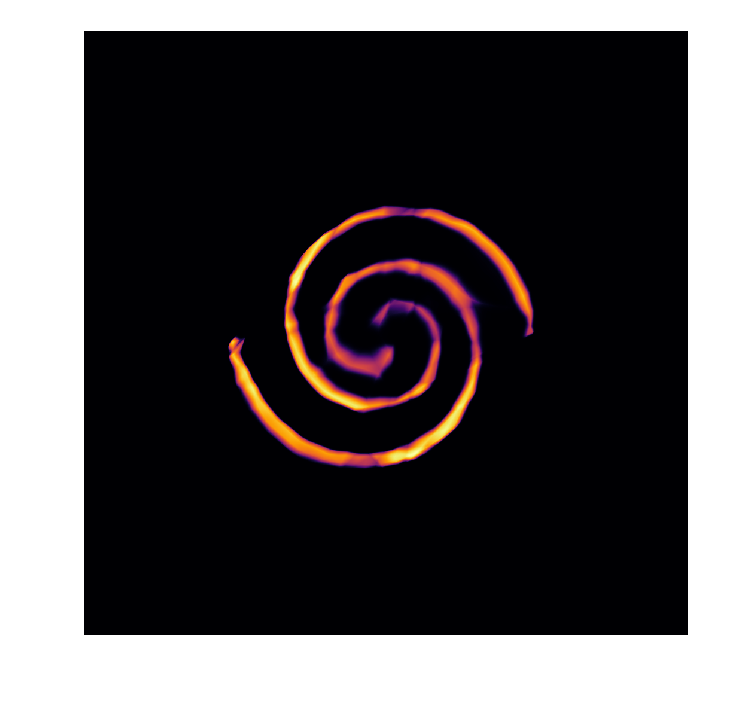

In [9]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()

plot_detector(detector, x=None, y=None, ax=ax, sess=sess)

plt.show()